In [1]:
!pip install ultralytics==8.3.124 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is

# Imports

In [22]:
import os
import glob
import yaml 
import random
import shutil
import torch 

import cv2
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO

# Constants

In [13]:
# --- Configuration ---
BASE_DATA_DIR = '/kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset'
ORIGINAL_DATA_DIR = os.path.join(BASE_DATA_DIR, 'Original_Data')
AUGMENTED_DATA_DIR = os.path.join(BASE_DATA_DIR, 'Augmented_Data')

# Define paths for augmented data splits
TRAIN_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'train', 'images')
TRAIN_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'train', 'labels')
VALID_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'valid', 'images')
VALID_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'valid', 'labels')
TEST_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'test', 'images')
TEST_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'test', 'labels')

# Class names corresponding to IDs 0-5
class_names = ['Caries', 'Infection', 'Impacted Teeth', 'Fractured Teeth', 'Broken Crown', 'Healthy']
num_classes = len(class_names)

# Using relative paths makes the yaml file more portable
INPUT_DATA_DIR = '/kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data'
TRAIN_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'train', 'images')
VALID_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'valid', 'images')
TEST_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'test', 'images')

# Output directory for the yaml file (in the working directory)
YAML_DIR = '/kaggle/working/'
yaml_file_path = os.path.join(YAML_DIR, 'dental_opg_dataset.yaml')

# Step1: Verify Folder Structure

In [4]:
def check_and_count_files(dir_path, extensions=['.jpg', '.txt', '.json']):
    """Checks if a directory exists and counts files with given extensions."""
    if not os.path.isdir(dir_path):
        print(f"Directory NOT FOUND: {dir_path}")
        return None
    
    counts = {ext: 0 for ext in extensions}
    all_files = glob.glob(os.path.join(dir_path, '*'))
    
    for f in all_files:
        for ext in extensions:
            if f.lower().endswith(ext):
                counts[ext] += 1
                break # Count each file only once based on the first matching extension
                
    count_str = ", ".join([f"{count} {ext}" for ext, count in counts.items() if count > 0])
    print(f"Found: {dir_path} - Contains: {count_str if count_str else '0 files specified'}")
    return counts

# Check Original Data
print("\n[Original Data]")
# Note: Original data description mentions .json labels, but the folder structure implies .txt. Let's check both.
# Correction based on user prompt: Original_Data also has .txt labels.
original_img_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.jpg'))
original_lbl_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.txt'))
print(f"Found: {ORIGINAL_DATA_DIR}")
print(f"  - Images (.jpg): {len(original_img_files)}")
print(f"  - Labels (.txt): {len(original_lbl_files)}")
# If JSON exists, check them too:
original_json_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.json'))
if original_json_files:
    print(f"  - Labels (.json): {len(original_json_files)}")


# Check Augmented Data
print("\n[Augmented Data]")
train_img_count = len(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))
train_lbl_count = len(glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt')))
valid_img_count = len(glob.glob(os.path.join(VALID_IMG_DIR, '*.jpg')))
valid_lbl_count = len(glob.glob(os.path.join(VALID_LBL_DIR, '*.txt')))
test_img_count = len(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')))
test_lbl_count = len(glob.glob(os.path.join(TEST_LBL_DIR, '*.txt')))

print(f"Train: Images={train_img_count}, Labels={train_lbl_count}")
print(f"Valid: Images={valid_img_count}, Labels={valid_lbl_count}")
print(f"Test:  Images={test_img_count}, Labels={test_lbl_count}")

# Basic consistency check
if train_img_count != train_lbl_count or valid_img_count != valid_lbl_count or test_img_count != test_lbl_count:
    print("\n*** WARNING: Mismatch between image and label counts in augmented data splits! ***")
else:
    print("\nImage and label counts match in augmented data splits.")


[Original Data]
Found: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Original_Data
  - Images (.jpg): 232
  - Labels (.txt): 232

[Augmented Data]
Train: Images=567, Labels=558
Valid: Images=23, Labels=23
Test:  Images=23, Labels=23

*** WARNING: Mismatch between image and label counts in augmented data splits! ***


## Step 2: Examine Label Format (YOLO Detection)

In [5]:
def examine_label_file_detection(label_path):
    """Reads a YOLO detection label file and prints its format info."""
    print(f"\nExamining: {label_path}")
    if not os.path.exists(label_path):
        print("File not found.")
        return None

    lines_info = []
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()

        if not lines:
            print("Label file is empty.")
            return []

        print(f"Number of bounding boxes (lines): {len(lines)}")

        for i, line in enumerate(lines):
            parts = line.strip().split()
            if len(parts) != 5: # Expecting class_id cx cy w h
                 print(f"  - Line {i+1}: Invalid format - expected 5 parts, found {len(parts)}. Content: '{line.strip()}'")
                 lines_info.append({'valid': False, 'parts': len(parts), 'content': line.strip()})
                 continue

            try:
                class_id = int(parts[0])
                cx = float(parts[1])
                cy = float(parts[2])
                w = float(parts[3])
                h = float(parts[4])
                coords = np.array([cx, cy, w, h])

                if not np.all((coords >= 0.0) & (coords <= 1.0)):
                    print(f"  - Line {i+1}: Invalid format - coordinates or dimensions out of [0, 1] range. Class: {class_id}, Values: {coords}")
                    lines_info.append({'valid': False, 'class': class_id, 'coords': coords.tolist(), 'content': line.strip()})
                else:
                    info = {'valid': True, 'class': class_id, 'cx': cx, 'cy': cy, 'w': w, 'h': h}
                    lines_info.append(info)
                    if i < 5: # Print details only for the first few lines
                         print(f"  - Line {i+1}: Class={class_id}, CenterX={cx:.4f}, CenterY={cy:.4f}, Width={w:.4f}, Height={h:.4f}")

            except ValueError:
                 print(f"  - Line {i+1}: Invalid format - non-numeric values found. Content: '{line.strip()}'")
                 lines_info.append({'valid': False, 'content': line.strip()})

    except Exception as e:
        print(f"Error reading or parsing {label_path}: {e}")
        return None

    return lines_info

# Examine one label file from the training set
sample_label_files = glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt'))
if sample_label_files:
    examine_label_file_detection(random.choice(sample_label_files))
else:
    print("No label files found in training set to examine.")


Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/138_jpg.rf.9f85e57967b23493c30b46a1528149cb.txt
Number of bounding boxes (lines): 14
  - Line 1: Class=5, CenterX=0.4691, CenterY=0.2588, Width=0.0701, Height=0.2118
  - Line 2: Class=5, CenterX=0.3479, CenterY=0.2823, Width=0.0562, Height=0.2256
  - Line 3: Class=5, CenterX=0.9345, CenterY=0.1088, Width=0.0825, Height=0.1870
  - Line 4: Class=2, CenterX=0.9156, CenterY=0.0181, Width=0.0719, Height=0.0361
  - Line 5: Class=0, CenterX=0.9141, CenterY=0.0208, Width=0.0781, Height=0.0417


## Step 3: Visualize Sample Images and Bounding Boxes


--- Visualizing Training Samples ---

Visualizing: 35_jpg.rf.8e02294724e5f6a68e0833003d6a2ed4.jpg
Image dimensions (HxW): 384 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/35_jpg.rf.8e02294724e5f6a68e0833003d6a2ed4.txt
Number of bounding boxes (lines): 2
  - Line 1: Class=5, CenterX=0.6906, CenterY=0.5885, Width=0.0594, Height=0.2344
  - Line 2: Class=5, CenterX=0.5406, CenterY=0.7552, Width=0.0500, Height=0.2188
Drawn 2 bounding boxes.


/tmp/ipykernel_31/936133588.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_classes) if unique_classes else 1)


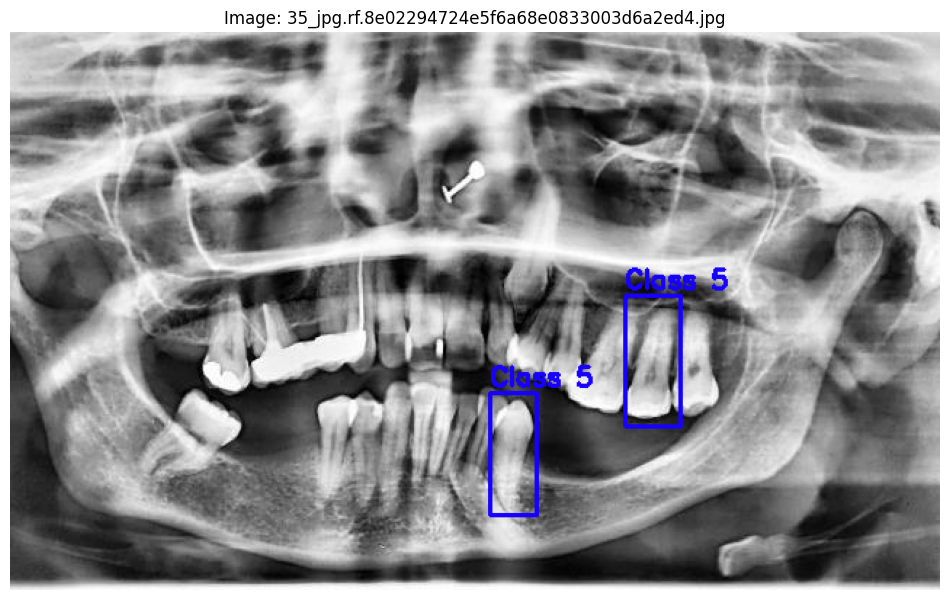


Visualizing: 173_jpg.rf.febc3847ac3fd231981724549cb1f9af.jpg
Image dimensions (HxW): 435 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/173_jpg.rf.febc3847ac3fd231981724549cb1f9af.txt
Number of bounding boxes (lines): 18
  - Line 1: Class=5, CenterX=0.2984, CenterY=0.0805, Width=0.0813, Height=0.1609
  - Line 2: Class=5, CenterX=0.0480, CenterY=0.3114, Width=0.0710, Height=0.1949
  - Line 3: Class=5, CenterX=0.0629, CenterY=0.1213, Width=0.0615, Height=0.1785
  - Line 4: Class=4, CenterX=0.8721, CenterY=0.3529, Width=0.0799, Height=0.1537
  - Line 5: Class=3, CenterX=0.8732, CenterY=0.1838, Width=0.0913, Height=0.1908
Drawn 18 bounding boxes.


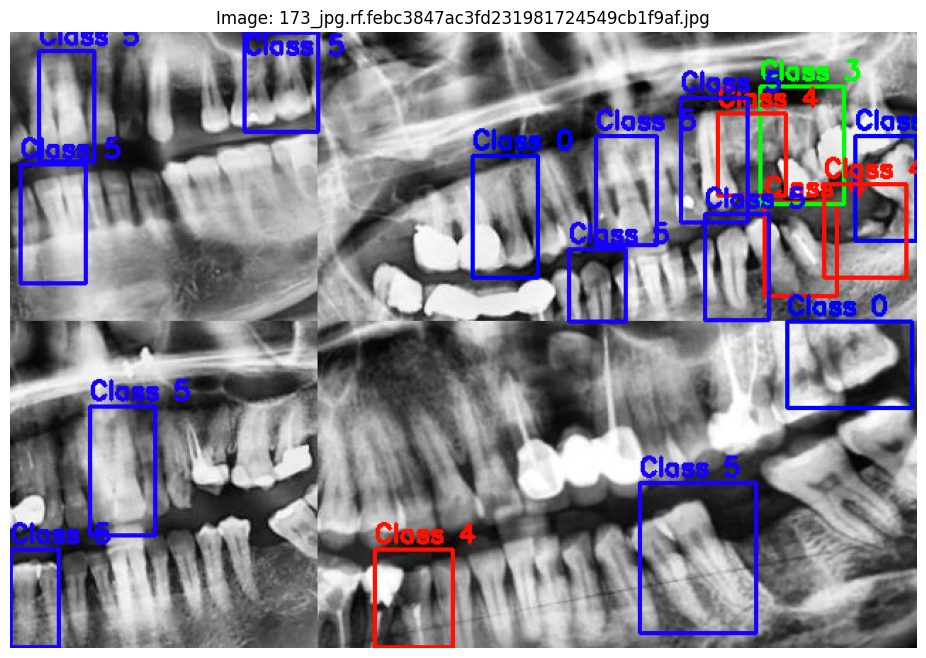


--- Visualizing Validation Samples ---

Visualizing: 231_jpg.rf.adc4c01feb3e4abf314a91641b08c92f.jpg
Image dimensions (HxW): 310 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels/231_jpg.rf.adc4c01feb3e4abf314a91641b08c92f.txt
Number of bounding boxes (lines): 5
  - Line 1: Class=5, CenterX=0.5266, CenterY=0.4806, Width=0.0453, Height=0.2710
  - Line 2: Class=5, CenterX=0.2516, CenterY=0.3871, Width=0.0594, Height=0.2419
  - Line 3: Class=5, CenterX=0.3031, CenterY=0.6968, Width=0.1094, Height=0.2968
  - Line 4: Class=5, CenterX=0.7922, CenterY=0.3871, Width=0.0437, Height=0.2387
  - Line 5: Class=5, CenterX=0.6531, CenterY=0.7323, Width=0.0672, Height=0.2484
Drawn 5 bounding boxes.


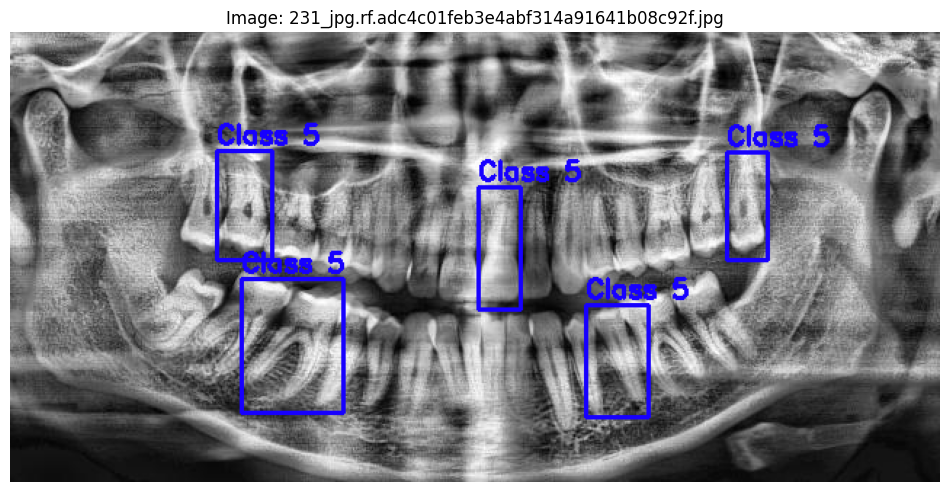


Visualizing: 184_jpg.rf.59618034addf45c96cc8f7a3a95199ab.jpg
Image dimensions (HxW): 318 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels/184_jpg.rf.59618034addf45c96cc8f7a3a95199ab.txt
Number of bounding boxes (lines): 1
  - Line 1: Class=5, CenterX=0.7375, CenterY=0.7547, Width=0.1250, Height=0.1824
Drawn 1 bounding boxes.


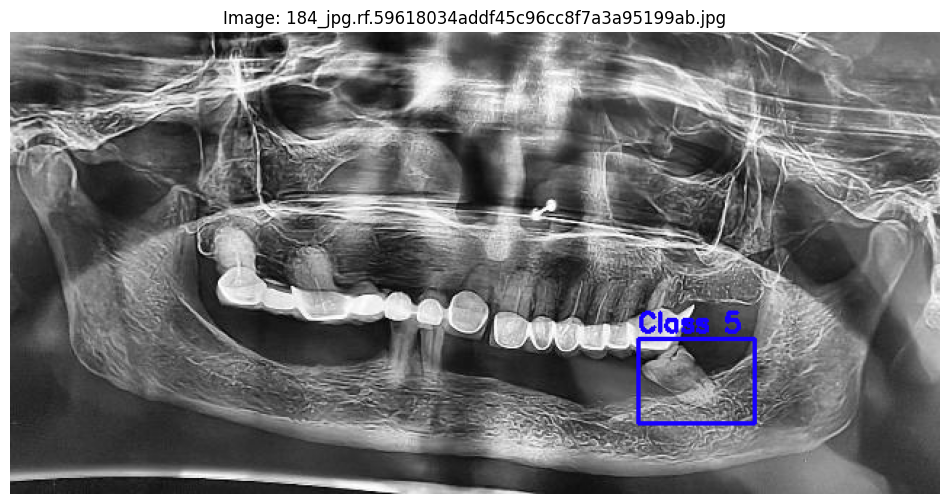


--- Visualizing Test Samples ---

Visualizing: 127_jpg.rf.c6c7a6eea86965354399e338b71fbc6a.jpg
Image dimensions (HxW): 274 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels/127_jpg.rf.c6c7a6eea86965354399e338b71fbc6a.txt
Number of bounding boxes (lines): 7
  - Line 1: Class=5, CenterX=0.4141, CenterY=0.6423, Width=0.0563, Height=0.3139
  - Line 2: Class=5, CenterX=0.7031, CenterY=0.3686, Width=0.0734, Height=0.2628
  - Line 3: Class=0, CenterX=0.2562, CenterY=0.6569, Width=0.0750, Height=0.2956
  - Line 4: Class=5, CenterX=0.4922, CenterY=0.3540, Width=0.0437, Height=0.2628
  - Line 5: Class=5, CenterX=0.5359, CenterY=0.6204, Width=0.0406, Height=0.3212
Drawn 7 bounding boxes.


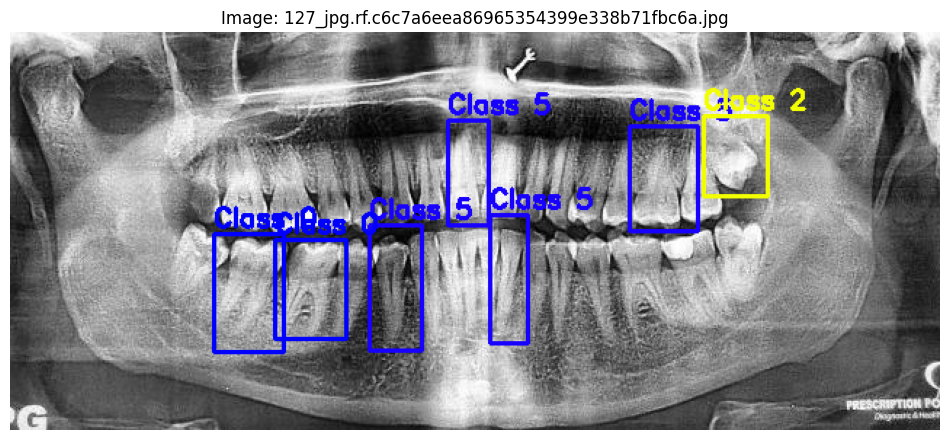


Visualizing: 202_jpg.rf.a22a84a217ada9172974f74fd39c4a08.jpg
Image dimensions (HxW): 329 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels/202_jpg.rf.a22a84a217ada9172974f74fd39c4a08.txt
Number of bounding boxes (lines): 4
  - Line 1: Class=5, CenterX=0.6469, CenterY=0.6960, Width=0.0969, Height=0.2523
  - Line 2: Class=5, CenterX=0.3109, CenterY=0.4650, Width=0.0594, Height=0.2158
  - Line 3: Class=5, CenterX=0.7188, CenterY=0.4863, Width=0.0813, Height=0.2097
  - Line 4: Class=2, CenterX=0.1938, CenterY=0.6353, Width=0.0953, Height=0.1611
Drawn 4 bounding boxes.


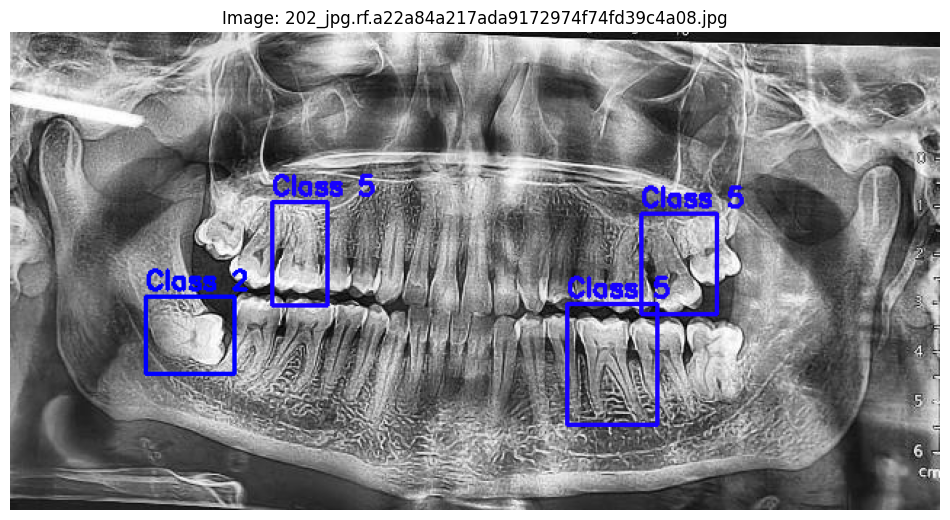

In [6]:
def display_image_with_boxes(image_path, label_path, num_samples=1):
    """Loads an image and its corresponding YOLO detection label, then displays them."""
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return
    if not os.path.exists(label_path):
        print(f"Label file not found: {label_path}")
        # Optionally display the image without boxes if label is missing
        # img = cv2.imread(image_path)
        # if img is not None:
        #     plt.figure(figsize=(10, 7))
        #     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #     plt.title(f"Image: {os.path.basename(image_path)} (No Label Found)")
        #     plt.axis('off')
        #     plt.show()
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return

    img_h, img_w = img.shape[:2]
    img_display = img.copy() # Work on a copy

    print(f"\nVisualizing: {os.path.basename(image_path)}")
    print(f"Image dimensions (HxW): {img_h} x {img_w}")

    lines_info = examine_label_file_detection(label_path) # Use updated examination function

    if lines_info is None or not lines_info:
        print("No valid bounding boxes found or error reading label file.")
    else:
        # Generate distinct colors for classes
        valid_classes = [info['class'] for info in lines_info if info['valid']]
        unique_classes = sorted(list(set(valid_classes))) if valid_classes else []
        # Use a colormap suitable for potentially many classes
        colors = plt.cm.get_cmap('hsv', len(unique_classes) if unique_classes else 1)
        class_colors = {cls: tuple(int(c*255) for c in colors(i)[:3]) for i, cls in enumerate(unique_classes)} # BGR for OpenCV

        box_count = 0
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5: continue # Skip invalid lines

                try:
                    class_id = int(parts[0])
                    cx = float(parts[1])
                    cy = float(parts[2])
                    w = float(parts[3])
                    h = float(parts[4])

                    # Denormalize coordinates and dimensions
                    center_x_abs = cx * img_w
                    center_y_abs = cy * img_h
                    box_w_abs = w * img_w
                    box_h_abs = h * img_h

                    # Calculate top-left (x1, y1) and bottom-right (x2, y2) coordinates
                    x1 = int(center_x_abs - box_w_abs / 2)
                    y1 = int(center_y_abs - box_h_abs / 2)
                    x2 = int(center_x_abs + box_w_abs / 2)
                    y2 = int(center_y_abs + box_h_abs / 2)

                    # Ensure coordinates are within image bounds (important for drawing)
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(img_w - 1, x2)
                    y2 = min(img_h - 1, y2)

                    color = class_colors.get(class_id, (0, 0, 255)) # Default to red if class not found
                    label_text = f"Class {class_id}" # You might want to map this to actual names later

                    # Draw the bounding box rectangle
                    cv2.rectangle(img_display, (x1, y1), (x2, y2), color, thickness=2)
                    # Add class label text above the box
                    cv2.putText(img_display, label_text, (x1, y1 - 5 if y1 > 10 else y1 + 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                    box_count += 1

                except Exception as e:
                    print(f"Error processing line for drawing: {line.strip()} - {e}")
        print(f"Drawn {box_count} bounding boxes.")


    # Display using Matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for plt
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

# Get lists of files (Keep as before)
train_image_files = sorted(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))
valid_image_files = sorted(glob.glob(os.path.join(VALID_IMG_DIR, '*.jpg')))
test_image_files = sorted(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')))

# Visualize a few samples from each split (Use updated function name)
num_samples_to_show = 2

print("\n--- Visualizing Training Samples ---")
for i in range(min(num_samples_to_show, len(train_image_files))):
    idx = random.randint(0, len(train_image_files)-1) # Pick random samples
    img_file = train_image_files[idx]
    lbl_file = os.path.join(TRAIN_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function

print("\n--- Visualizing Validation Samples ---")
for i in range(min(num_samples_to_show, len(valid_image_files))):
    idx = random.randint(0, len(valid_image_files)-1)
    img_file = valid_image_files[idx]
    lbl_file = os.path.join(VALID_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function

print("\n--- Visualizing Test Samples ---")
for i in range(min(num_samples_to_show, len(test_image_files))):
    idx = random.randint(0, len(test_image_files)-1)
    img_file = test_image_files[idx]
    lbl_file = os.path.join(TEST_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function



## Step 4: Basic Statistics

In [7]:
image_widths = []
image_heights = []
boxes_per_image = [] # Changed name from segments_per_image
all_class_ids = set()
empty_label_files = 0

train_label_files = sorted(glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt')))

for lbl_file in train_label_files:
    img_file = os.path.join(TRAIN_IMG_DIR, os.path.basename(lbl_file).replace('.txt', '.jpg'))

    if not os.path.exists(img_file):
        print(f"Warning: Corresponding image not found for label {lbl_file}")
        continue

    # Image dimensions (Keep as before)
    try:
        # Optimization: Use cv2.imread only once if needed for both stats and visualization later
        # Or use a library like PIL to get dimensions without loading the full image if memory is a concern
        img = cv2.imread(img_file)
        if img is not None:
            h, w = img.shape[:2]
            image_heights.append(h)
            image_widths.append(w)
        else:
            print(f"Warning: Could not read image {img_file}")
            continue
    except Exception as e:
        print(f"Error reading image {img_file}: {e}")
        continue

    # Label info (Logic adapted for detection format)
    try:
        with open(lbl_file, 'r') as f:
            lines = f.readlines()

        num_boxes = 0
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5: # Check for valid detection line format
                num_boxes += 1
                try:
                    all_class_ids.add(int(parts[0]))
                except ValueError:
                    print(f"Warning: Non-integer class ID found in {lbl_file}: {parts[0]}")
            elif parts: # If line is not empty but has wrong format
                 print(f"Warning: Invalid line format in {lbl_file}: '{line.strip()}'")


        boxes_per_image.append(num_boxes)

        if num_boxes == 0 and lines: # Label file exists but has no valid lines or is empty
             print(f"Warning: Label file {lbl_file} seems empty or contains only invalid lines.")
             if not lines:
                 empty_label_files += 1 # Count files that are truly empty


    except Exception as e:
        print(f"Error reading or processing label file {lbl_file}: {e}")

# Summary (Keep variable names consistent)
print(f"\nStatistics based on {len(train_label_files)} training labels:")
if image_widths:
    print(f"Image Widths: Min={np.min(image_widths)}, Max={np.max(image_widths)}, Avg={np.mean(image_widths):.2f}")
    print(f"Image Heights: Min={np.min(image_heights)}, Max={np.max(image_heights)}, Avg={np.mean(image_heights):.2f}")
    # Consider plotting histograms if needed
    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    # plt.hist(image_widths, bins=20)
    # plt.title('Image Width Distribution (Train)')
    # plt.subplot(1, 2, 2)
    # plt.hist(image_heights, bins=20)
    # plt.title('Image Height Distribution (Train)')
    # plt.tight_layout()
    # plt.show()

if boxes_per_image:
    print(f"Bounding Boxes per Image: Min={np.min(boxes_per_image)}, Max={np.max(boxes_per_image)}, Avg={np.mean(boxes_per_image):.2f}")
    print(f"Number of completely empty label files: {empty_label_files}") # Clarified meaning
    # Consider plotting histogram
    # plt.figure(figsize=(6, 4))
    # plt.hist(boxes_per_image, bins=max(10, np.max(boxes_per_image) // 2 if np.max(boxes_per_image) > 0 else 10)) # Adjust bins
    # plt.title('Boxes per Image Distribution (Train)')
    # plt.show()

print(f"Unique Class IDs found: {sorted(list(all_class_ids))}")
if len(all_class_ids) > 0:
    print(f"This confirms a detection task with {len(all_class_ids)} classes.")
    print("You will need to define the names for these classes in your dataset.yaml file.")
else:
     print("Warning: No valid class IDs were found in the training labels.")




Statistics based on 558 training labels:
Image Widths: Min=639, Max=640, Avg=639.99
Image Heights: Min=250, Max=485, Avg=349.64
Bounding Boxes per Image: Min=1, Max=25, Avg=10.11
Number of completely empty label files: 0
Unique Class IDs found: [0, 1, 2, 3, 4, 5]
This confirms a detection task with 6 classes.
You will need to define the names for these classes in your dataset.yaml file.


## Step 5: Create Dataset.yaml File

In [15]:
dataset_yaml_content = f"""
path: {os.path.abspath(INPUT_DATA_DIR)} # Absolute path can sometimes be more reliable inside the library
train: {os.path.abspath(TRAIN_IMG_DIR_REL)} # Path to train images
val: {os.path.abspath(VALID_IMG_DIR_REL)}   # Path to validation images
test: {os.path.abspath(TEST_IMG_DIR_REL)}  # Path to test images (optional)

# Classes
nc: {num_classes}
names: {class_names}
"""

# Write the content to the YAML file
os.makedirs(YAML_DIR, exist_ok=True) # Ensure the directory exists
with open(yaml_file_path, 'w') as f:
    f.write(dataset_yaml_content)

print(f"--- dataset.yaml created at: {yaml_file_path} ---")
print("Content:")
print(dataset_yaml_content)
print("-" * 30)

--- dataset.yaml created at: /kaggle/working/dental_opg_dataset.yaml ---
Content:

path: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data # Absolute path can sometimes be more reliable inside the library
train: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/images # Path to train images
val: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/images   # Path to validation images
test: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/images  # Path to test images (optional)

# Classes
nc: 6
names: ['Caries', 'Infection', 'Impacted Teeth', 'Fractured Teeth', 'Broken Crown', 'Healthy']

------------------------------


## Step 6: Configure Training Parameters

In [18]:
model_name = 'yolov10m.pt'

# Training hyperparameters
EPOCHS = 75  # Start with a reasonable number, can adjust based on val performance
IMG_SIZE = 640 # Input images will be resized to this (common default, matches data width)
BATCH_SIZE = 16 # Adjust based on GPU memory (16 is usually okay for T4/P100 with yolov8m)
PATIENCE = 30 # Early stopping patience: stops training if no improvement after 'patience' epochs
PROJECT_NAME = 'Dental_OPG_Detection' # Directory to save runs
RUN_NAME = 'yolov10m_e75_batch16' # Specific name for this training run

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cpu':
    print("WARNING: Training on CPU will be very slow. Ensure GPU is enabled in Kaggle settings.")
    # Consider reducing batch size or using a smaller model (yolov8n) if stuck on CPU
    # BATCH_SIZE = max(2, BATCH_SIZE // 4) # Example adjustment for CPU

Using device: cuda


## Step 7: Initialize and Train the Model

In [19]:
print(f"\n--- Initializing YOLO model: {model_name} ---")
model = YOLO(model_name)

print(f"\n--- Starting Training ---")
print(f"   Data YAML: {yaml_file_path}")
print(f"   Epochs: {EPOCHS}")
print(f"   Image Size: {IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Patience: {PATIENCE}")
print(f"   Project: {PROJECT_NAME}")
print(f"   Run Name: {RUN_NAME}")
print("-" * 30)


--- Initializing YOLO model: yolov10m.pt ---


100%|██████████| 32.1M/32.1M [00:00<00:00, 180MB/s]



--- Starting Training ---
   Data YAML: /kaggle/working/dental_opg_dataset.yaml
   Epochs: 75
   Image Size: 640
   Batch Size: 16
   Patience: 30
   Project: Dental_OPG_Detection
   Run Name: yolov10m_e75_batch16
------------------------------


In [20]:
# Start training
try:
    results = model.train(
        data=yaml_file_path,
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        patience=PATIENCE,
        device=device,          # Explicitly set device
        project=PROJECT_NAME,   # Saves runs to /kaggle/working/Dental_OPG_Detection/
        name=RUN_NAME,          # Subdirectory name within the project folder
        exist_ok=False,         # Set to True if you want to overwrite previous runs with the same name
        # Augmentation parameters can be adjusted here if needed, defaults are usually good.
        # e.g., degrees=10, translate=0.1, scale=0.1, flipud=0.5 ...
        # cache=True, # Cache images in RAM for faster training (if RAM allows)
    )
    print("\n--- Training Completed Successfully ---")

except Exception as e:
    print(f"\n--- Training Interrupted/Failed ---")
    print(f"Error: {e}")

Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10m.pt, data=/kaggle/working/dental_opg_dataset.yaml, epochs=75, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=Dental_OPG_Detection, name=yolov10m_e75_batch16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

100%|██████████| 755k/755k [00:00<00:00, 16.6MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1     78720  ultralytics.nn.modules.block.SCDown          [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1    228672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 73.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.8±0.5 ms, read: 94.3±18.9 MB/s, size: 44.8 KB)


train: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels... 558 images, 9 backgrounds, 0 corrupt: 100%|██████████| 567/567 [00:00<00:00, 653.96it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.3±0.4 ms, read: 26.1±41.5 MB/s, size: 38.9 KB)


val: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 212.44it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid is not writeable, cache not saved.


Plotting labels to Dental_OPG_Detection/yolov10m_e75_batch16/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to Dental_OPG_Detection/yolov10m_e75_batch16
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75      8.27G      3.981      6.975      3.452        129        640: 100%|██████████| 36/36 [00:22<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all         23        115      0.806     0.0334     0.0389     0.0174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      8.33G      3.489      4.679      3.098        143        640: 100%|██████████| 36/36 [00:21<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         23        115      0.355    0.00746    0.00955    0.00311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75      8.37G       3.41      4.285       3.02        154        640: 100%|██████████| 36/36 [00:21<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         23        115       0.92      0.112      0.126     0.0701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75       8.4G      3.348      4.088      2.995        124        640: 100%|██████████| 36/36 [00:21<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         23        115      0.406      0.252      0.143     0.0683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      8.37G      3.327      3.882      2.991        139        640: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23        115      0.286      0.228      0.132      0.046



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      8.37G      3.289      3.757       2.91        114        640: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         23        115      0.351      0.307        0.3      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75       8.4G      3.249      3.658      2.915        148        640: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         23        115      0.659      0.222      0.262      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      8.39G      3.087      3.491      2.851        124        640: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         23        115      0.706      0.312      0.346      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75      8.35G      3.143      3.476      2.874        145        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23        115      0.472      0.411      0.359      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75       8.4G      3.043      3.293       2.79        138        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23        115      0.746      0.372      0.386      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75      8.41G       2.96      3.122      2.752        144        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         23        115      0.502      0.439      0.394      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75       8.4G      2.989      3.121      2.762        130        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23        115      0.692      0.379      0.448      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      8.41G      2.986      3.003      2.771         79        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         23        115      0.548      0.375       0.34       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      8.38G      2.999      2.979       2.79         87        640: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         23        115        0.5       0.44      0.379      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      8.36G      2.915      2.889      2.687        124        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         23        115      0.614      0.396      0.428      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75      8.39G      2.802      2.772      2.635        142        640: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23        115      0.561      0.425      0.487      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      8.38G      2.825      2.637      2.626        156        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         23        115      0.742      0.416      0.469      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      8.41G      2.751      2.511       2.65        144        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23        115      0.518      0.534      0.515       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      8.35G      2.701      2.466      2.604        140        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23        115      0.561      0.578      0.545      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75       8.4G      2.758      2.433      2.613        107        640: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         23        115      0.535      0.624      0.538      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      8.44G      2.733        2.4      2.618        121        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23        115      0.697       0.49      0.541      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      8.39G      2.625      2.281      2.553        152        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         23        115      0.639      0.615      0.587      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      8.39G      2.652      2.225      2.563        112        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         23        115      0.621      0.664      0.664        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      8.33G      2.596      2.145      2.511        154        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23        115      0.645      0.553      0.593      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75       8.4G       2.61      2.074      2.512        156        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23        115      0.548       0.53       0.59      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75      8.36G      2.545      2.007      2.495        123        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23        115      0.541      0.675      0.636      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75       8.4G      2.475      1.961      2.497        115        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         23        115      0.763      0.584      0.696      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      8.42G      2.477        1.9      2.503        130        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23        115      0.785      0.663      0.763      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      8.35G      2.416      1.849      2.435        157        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23        115      0.648      0.635      0.626      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      8.39G      2.437      1.798       2.42        153        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         23        115      0.786      0.616      0.696      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75      8.36G      2.416      1.794      2.463        140        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         23        115       0.77      0.592      0.679      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75      8.36G      2.356      1.703      2.392        107        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23        115      0.822      0.655      0.796      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75      8.35G      2.347      1.746      2.388        116        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23        115      0.643      0.729       0.73      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      8.39G      2.349      1.665      2.419        120        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23        115      0.683      0.703      0.757       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      8.42G      2.326      1.595      2.359        158        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23        115      0.648      0.662      0.705      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      8.37G      2.275      1.579      2.325        135        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23        115      0.769       0.72      0.776      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      8.39G      2.304      1.558      2.373        116        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23        115      0.758      0.641      0.737      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75      8.38G       2.25       1.51      2.296        141        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23        115      0.815      0.654      0.802      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      8.35G      2.159       1.43      2.255        111        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23        115      0.773      0.732      0.769      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75      8.39G      2.142      1.439      2.254        109        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         23        115      0.859      0.827      0.868       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      8.41G      2.153      1.429      2.255        146        640: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23        115      0.853      0.727      0.814      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75      8.35G       2.14      1.421      2.263        104        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23        115       0.85      0.676      0.782      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75      8.35G      2.078      1.347      2.236        116        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23        115      0.792       0.75      0.812       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75       8.4G      2.097      1.355      2.252        129        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23        115      0.861      0.706      0.815      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      8.36G      2.064      1.307      2.234        146        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23        115      0.771      0.826      0.829       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75      8.42G      2.044      1.296      2.211        125        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23        115       0.82      0.767      0.832      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      8.42G      2.015      1.264      2.184        124        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23        115      0.838      0.737      0.806      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      8.41G      1.968      1.262      2.213        118        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         23        115      0.815        0.7      0.792      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75      8.38G      1.985      1.263      2.178        148        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         23        115      0.738      0.715      0.795      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75      8.41G      1.954      1.212      2.155        110        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         23        115      0.807      0.775      0.836      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75      8.35G      1.939      1.203      2.165        103        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23        115      0.835      0.782      0.824      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75      8.42G       1.88      1.158      2.117        100        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         23        115      0.855      0.816      0.851      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75      8.38G      1.838      1.126      2.119        132        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         23        115      0.836      0.823      0.892      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75       8.4G      1.847      1.117      2.115        114        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         23        115      0.879      0.771      0.881      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      8.39G      1.801       1.12      2.116        133        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23        115      0.762       0.81       0.81      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75      8.35G       1.81      1.118       2.09        169        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         23        115      0.896      0.709      0.845      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75      8.35G       1.81      1.103      2.104        158        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         23        115      0.885      0.834      0.872      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75      8.38G      1.785      1.064      2.088        177        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         23        115      0.901      0.856      0.901      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75      8.41G       1.76      1.049      2.074        118        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23        115       0.91      0.795      0.904      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75      8.42G      1.721       1.04      2.059         98        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         23        115      0.878      0.766      0.911      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75      8.39G      1.701      1.008      2.052        141        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         23        115      0.856      0.852      0.921      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      8.41G      1.656      1.001      2.019        131        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23        115      0.856      0.817      0.895      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75      8.42G      1.675      1.001       2.01        170        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23        115      0.898      0.795      0.859      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75      8.41G       1.63     0.9937      2.028        134        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         23        115      0.872      0.804      0.863      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75      8.38G      1.587     0.9529      1.984        123        640: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         23        115      0.861      0.769      0.855      0.578


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75      8.35G       1.63     0.8576       2.09         68        640: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         23        115      0.762      0.817      0.824      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75      8.35G      1.522      0.787      2.024         81        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         23        115      0.721      0.801      0.848      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75      8.35G      1.438     0.7387      2.013         64        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23        115      0.837      0.752      0.869       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75      8.35G      1.438     0.7382      1.978         83        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         23        115      0.771      0.839      0.856      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      8.37G      1.398     0.7299      1.989         65        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         23        115      0.734      0.803      0.863       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75      8.37G      1.385     0.7045      1.969         82        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23        115       0.92       0.74      0.876      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75      8.34G       1.41     0.6978      1.949         43        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         23        115      0.819      0.813      0.893      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75      8.34G      1.335     0.6739      1.956         66        640: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23        115      0.906      0.801        0.9       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75      8.38G      1.313     0.6592      1.917         69        640: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         23        115      0.771      0.811      0.871      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75      8.38G      1.317     0.6687      1.921         69        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         23        115       0.79      0.831      0.873       0.61



75 epochs completed in 0.527 hours.
Optimizer stripped from Dental_OPG_Detection/yolov10m_e75_batch16/weights/last.pt, 33.5MB
Optimizer stripped from Dental_OPG_Detection/yolov10m_e75_batch16/weights/best.pt, 33.5MB

Validating Dental_OPG_Detection/yolov10m_e75_batch16/weights/best.pt...
Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,316,642 parameters, 0 gradients, 58.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


                   all         23        115      0.906        0.8      0.901       0.62
                Caries          8         14      0.746      0.929      0.891      0.672
             Infection          3          4          1      0.499      0.754      0.489
        Impacted Teeth          7         18      0.907      0.944      0.984      0.657
       Fractured Teeth          3          3          1      0.891      0.995      0.628
          Broken Crown          6          9      0.985      0.889      0.984      0.685
               Healthy         22         67      0.798       0.65      0.798      0.589


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 7.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to Dental_OPG_Detection/yolov10m_e75_batch16

--- Training Completed Successfully ---


## Step8: Model Testing & Validation

In [23]:
import os
from ultralytics import YOLO
import torch

# --- 1. Define Paths and Parameters ---

# Reuse variables from the training script if possible, or redefine them
PROJECT_NAME = 'Dental_OPG_Detection'
RUN_NAME = 'yolov10m_e75_batch16' # Make sure this matches the run name used during training
MODEL_WEIGHTS_PATH = os.path.join('/kaggle/working/', PROJECT_NAME, RUN_NAME, 'weights', 'best.pt')
YAML_DIR = '/kaggle/working/' # Directory where the yaml file was saved
yaml_file_path = os.path.join(YAML_DIR, 'dental_opg_dataset.yaml')
IMG_SIZE = 640 # Use the same image size as during training

# Check if the model weights file exists
if not os.path.exists(MODEL_WEIGHTS_PATH):
    print(f"ERROR: Model weights not found at: {MODEL_WEIGHTS_PATH}")
    print("Please ensure the training completed successfully and the PROJECT_NAME/RUN_NAME are correct.")
    # You might need to list directories in /kaggle/working/ to find the correct path
    # import glob
    # print("Available runs:", glob.glob('/kaggle/working/Dental_OPG_Detection/*/weights/best.pt'))
else:
    print(f"Found model weights: {MODEL_WEIGHTS_PATH}")
    print(f"Using dataset configuration: {yaml_file_path}")

    # Check for GPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # --- 2. Load the Trained Model ---
    print("\n--- Loading trained model ---")
    model = YOLO(MODEL_WEIGHTS_PATH)

    # --- 3. Run Validation on the Test Set ---
    print(f"\n--- Evaluating model on the 'test' split ---")

    # The model.val() method runs evaluation
    # Setting split='test' tells it to use the 'test:' path from your dataset.yaml
    metrics = model.val(
        data=yaml_file_path,
        split='test',
        imgsz=IMG_SIZE,
        batch=16, # Adjust based on GPU memory if needed, should be fine for inference
        device=device,
        project=PROJECT_NAME, # Optional: Save results under the same project
        name=RUN_NAME + '_test_eval', # Optional: Give a specific name to this evaluation run
        save_json=True, # Save results statistics in JSON format (recommended)
        save_hybrid=False, # Saves labels with preds too - can be useful but creates many files
        conf=0.25, # Confidence threshold for evaluation (default 0.001, mAP uses thresholds internally anyway)
        iou=0.7 # IoU threshold for NMS - doesn't directly impact mAP calculation much but affects PR curve points
    )

    print("\n--- Evaluation Complete ---")

    # --- 4. Access and Display Metrics ---
    # The 'metrics' object holds the results. Key metrics are in metrics.box:
    print("\n--- Performance Metrics on Test Set ---")
    print(f"mAP50-95 (Primary Metric): {metrics.box.map:.4f}")
    print(f"mAP50 (IoU=0.50):         {metrics.box.map50:.4f}")
    print(f"mAP75 (IoU=0.75):         {metrics.box.map75:.4f}")
    print("-" * 20)
    # Precision and Recall are typically reported averaged over classes at the optimal F1 score threshold
    # Note: metrics.results_dict might contain per-class P, R, F1 if calculated,
    # but the main output usually focuses on mAP. The printed summary during execution shows P & R.
    # Or access them directly if needed (may vary slightly based on ultralytics version):
    try:
        precision = metrics.box.mp # Mean precision
        recall = metrics.box.mr    # Mean recall
        print(f"Mean Precision:           {precision:.4f}")
        print(f"Mean Recall:              {recall:.4f}")
    except AttributeError:
        print("Precision/Recall attributes (mp, mr) might not be directly available in this version.")
        print("Check the console output during model.val() execution for Precision and Recall values.")


    print("-" * 20)
    print("Per-class mAP50-95:")
    for i, name in enumerate(metrics.names.values()):
         print(f"  - {name}: {metrics.box.maps[i]:.4f}") # maps is the array of mAP50-95 per class

    print(f"\nEvaluation results saved in: /kaggle/working/{PROJECT_NAME}/{RUN_NAME}_test_eval")
    print("Check this directory for:")
    print("  - confusion_matrix.png")
    print("  - P_curve.png (Precision-Confidence curve)")
    print("  - R_curve.png (Recall-Confidence curve)")
    print("  - PR_curve.png (Precision-Recall curve)")
    print("  - F1_curve.png (F1-Confidence curve)")
    print("  - results.csv (Detailed metrics)")
    print("  - results.json (If save_json=True)")
    print("  - Images with predicted bounding boxes overlaid.")

Found model weights: /kaggle/working/Dental_OPG_Detection/yolov10m_e75_batch16/weights/best.pt
Using dataset configuration: /kaggle/working/dental_opg_dataset.yaml
Using device: cuda

--- Loading trained model ---

--- Evaluating model on the 'test' split ---
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,316,642 parameters, 0 gradients, 58.9 GFLOPs
val: Fast image access ✅ (ping: 2.1±0.4 ms, read: 25.5±44.1 MB/s, size: 42.7 KB)


val: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 220.37it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


                   all         23        102        0.9       0.83      0.896      0.677
                Caries         14         26       0.88      0.846      0.884      0.674
             Infection          2          5          1        0.6        0.8      0.586
        Impacted Teeth          7         12      0.923          1      0.989      0.772
          Broken Crown          4          5      0.833          1      0.995      0.738
               Healthy         23         54      0.864      0.704       0.81      0.614


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.8ms preprocess, 29.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Saving Dental_OPG_Detection/yolov10m_e75_batch16_test_eval/predictions.json...
Results saved to Dental_OPG_Detection/yolov10m_e75_batch16_test_eval

--- Evaluation Complete ---

--- Performance Metrics on Test Set ---
mAP50-95 (Primary Metric): 0.6767
mAP50 (IoU=0.50):         0.8956
mAP75 (IoU=0.75):         0.8846
--------------------
Mean Precision:           0.9000
Mean Recall:              0.8300
--------------------
Per-class mAP50-95:
  - Caries: 0.6735
  - Infection: 0.5863
  - Impacted Teeth: 0.7719
  - Fractured Teeth: 0.6767
  - Broken Crown: 0.7380
  - Healthy: 0.6138

Evaluation results saved in: /kaggle/working/Dental_OPG_Detection/yolov10m_e75_batch16_test_eval
Check this directory for:
  - confusion_matrix.png
  - P_curve.png (Precision-Confidence curve)
  - R_curve.png (Recall-Confidence curve)
  - PR_curve.png (Precision-Recall curve)
  - F1_curve.png (F1-Confidence curve)
  - results.c

## Step9: Model Export

In [21]:
import shutil
import os

# Set source and output zip file path
source_dir = '/kaggle/working/Dental_OPG_Detection/yolov10m_e75_batch16'
output_zip = '/kaggle/working/yolov10m_e75_batch16.zip'

# Zip the directory
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=source_dir)

print(f"Zipped directory saved to: {output_zip}")


Zipped directory saved to: /kaggle/working/yolov10m_e75_batch16.zip
